In [349]:
%load_ext autoreload
%autoreload 2
from src.catalogs import (
    JapanSlowSlipCatalog,
    RoussetSlowSlipCatalog, 
    XieSlowSlipCatalog,
    WilliamsSlowSlipCatalog,
    MichelSlowSlipCatalog 
)

from src.data import (
    AllSlabs, 
    EarthquakeCatalog,
    SlowSlipCatalog,
    Scaling
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import gaussian_kde
from tqdm import tqdm

import warnings

import src
from pathlib import Path
base_dir = Path(src.__file__).parents[1]

mpl.rc('figure',dpi=300)
mpl.rc('font',size=8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Global analysis of slow slip

## Datasets

`AllSlabs` loads in all the slab geometries from Slab2.0

In [3]:
all_slabs = AllSlabs()

We now load in all the slow slip datasets. Please refer to `Datasets/Slow_slip_datasets` for detailed metadata for each datasets.

In [166]:

slowslip = [
    catalog() for catalog in [
        JapanSlowSlipCatalog,
        RoussetSlowSlipCatalog, 
        XieSlowSlipCatalog,
        WilliamsSlowSlipCatalog,
    ]
]
all_slowslip = sum(slowslip[1:], slowslip[0])

/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/catalog.py:69: UserWarning: Catalog does not have depth column, this may cause errors.
  warnings.warn(


In [5]:
minimum_magnitude = 4
earthquakes = EarthquakeCatalog(
    filename=base_dir / "Datasets" / "Seismicity_datasets" / "global_earthquakes.csv",
    use_other_catalog=True,
    other_catalog=all_slowslip,
    other_catalog_buffer=5, # buffer in degrees
    kwargs={"minimum_magnitude":minimum_magnitude},
)

/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:87: UserWarning: Longitude range exceeds 180 degrees. Setting to 180.
  warnings.warn("Longitude range exceeds 180 degrees. Setting to 180.")
/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:179: UserWarning: Using existing /Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/Datasets/Seismicity_datasets/global_earthquakes.csv
  warnings.warn(f"Using existing {filename}")
/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:185: UserWarning: 318 NaN values found in catalog. Removing rows with NaN values.
  warnings.warn(


In [369]:
local_earthquakes = earthquakes.intersection(all_slowslip,buffer_radius_km=200.0)
distance_to_slab = all_slabs.distance(
    local_earthquakes.catalog[["lat","lon","depth"]].values,
    depth_unit="km",
    distance_unit="km",
)
local_earthquakes = EarthquakeCatalog(local_earthquakes.catalog.loc[distance_to_slab < 20])

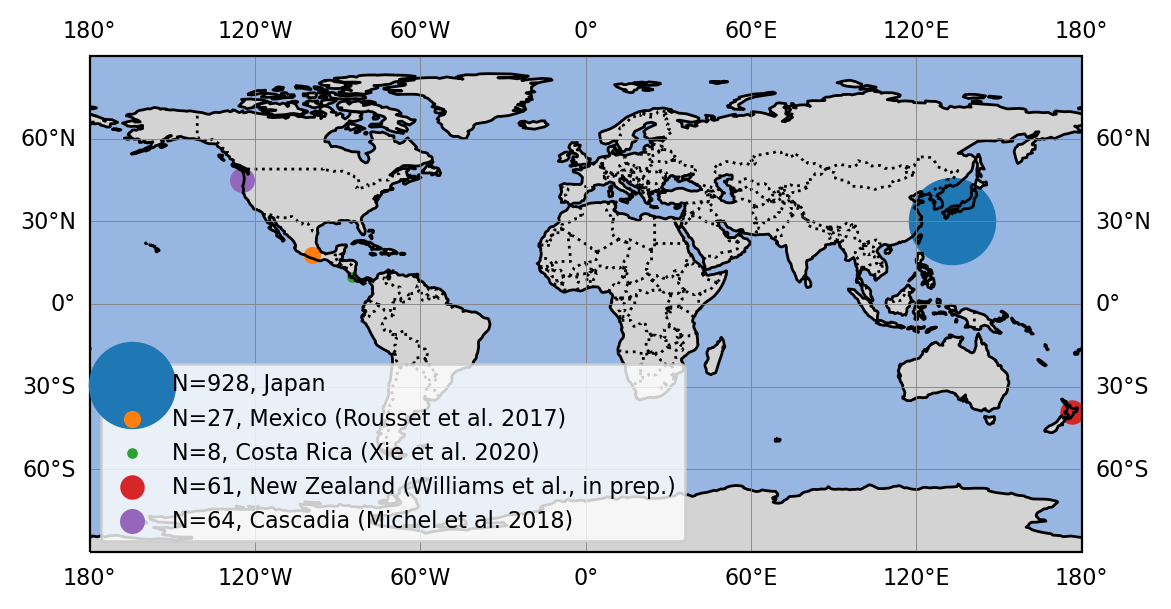

In [7]:
_, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
usemap_proj = ccrs.PlateCarree()
# set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
extent = [-180,180,-90,90]

ax.set_extent(
    extent,
    crs=ccrs.PlateCarree(),
)

ax.add_feature(cfeature.LAND, color="lightgray")
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# plot grid lines
ax.gridlines(draw_labels=True, crs=usemap_proj, color="gray", linewidth=0.3)

for i_slowslip in slowslip:
    ax.scatter(
        np.mean(i_slowslip.longitude_range),
        np.mean(i_slowslip.latitude_range),
        s=len(i_slowslip),
        label=f"N={len(i_slowslip)}, {i_slowslip.name}",
    )

ax.legend(loc='lower left')

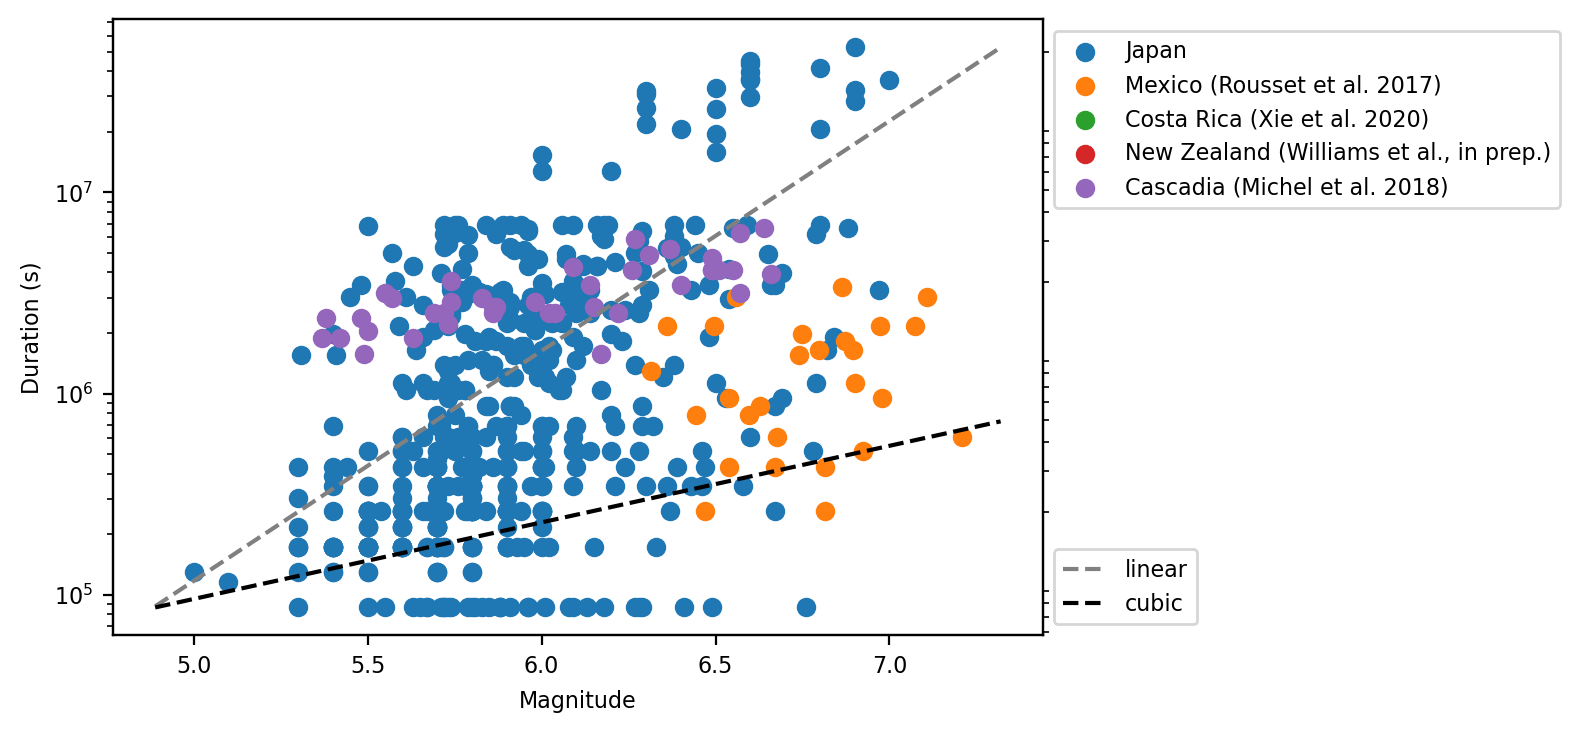

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
for i_slowslip in slowslip:
    ax.scatter(
        i_slowslip.catalog['mag'],
        i_slowslip.catalog['duration'],
        label=i_slowslip.name,
    )
ax.set(
    xlabel='Magnitude',
    ylabel='Duration (s)',
    yscale='log',
)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
xlim = np.array(ax.get_xlim())
axb = ax.twinx()
axb.plot(xlim, 10**xlim, '--', c='grey', label='linear')
axb.plot(xlim, 10**(0.666*xlim[0])*10**(0.333*xlim), '--', c='k', label='cubic')
axb.set(
    yscale='log',
    yticks=[],
)
axb.legend(loc='lower left', bbox_to_anchor=(1,0))


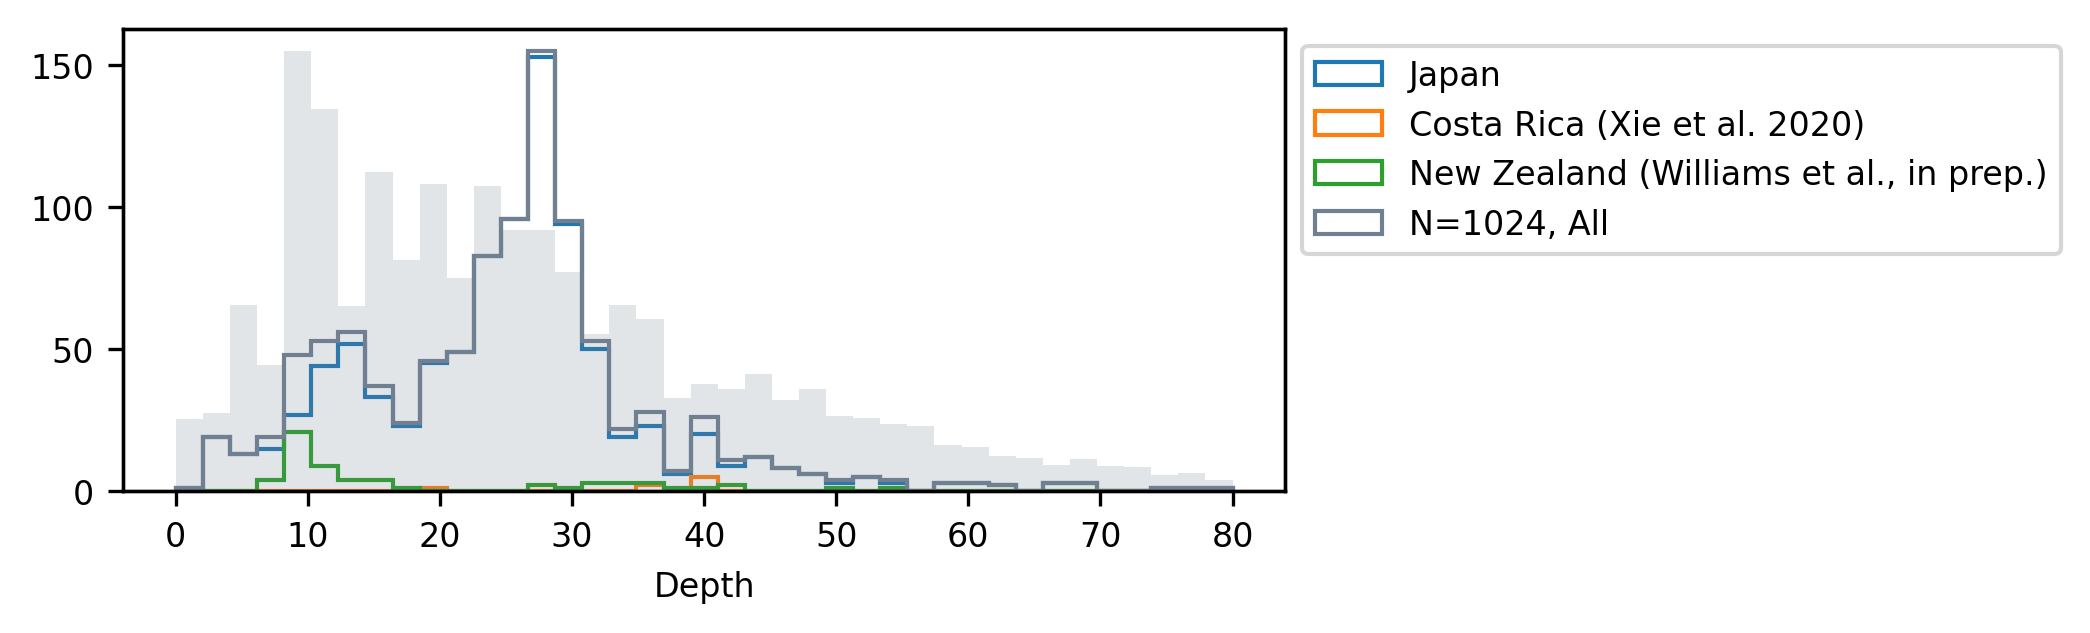

In [373]:
fig, ax = plt.subplots(1, 1, figsize=(5,2))
bins = np.linspace(0, 80, 40)
axb = ax.twinx()
axb.hist(
    local_earthquakes.catalog.depth, 
    bins=bins, 
    label=f'N={len(local_earthquakes.slice_by("depth",0,80))}, M{minimum_magnitude}+ Earthquakes', color='slategray', alpha=0.2
)
axb.set(yticklabels=[],yticks=[])
all_depths = []
for i_slowslip in slowslip:
    if 'depth' in i_slowslip.catalog.columns:
        ax.hist(
            i_slowslip.catalog['depth'],
            bins = bins,
            label=i_slowslip.name,
            histtype='step',
        )
        all_depths.append(i_slowslip.catalog['depth'])
ax.hist(
    np.concatenate(all_depths),
    bins = bins,
    label=f'N={len(all_slowslip)}, All',
    histtype='step',
    color='slategray',
)
ax.set(
    xlabel='Depth',
)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

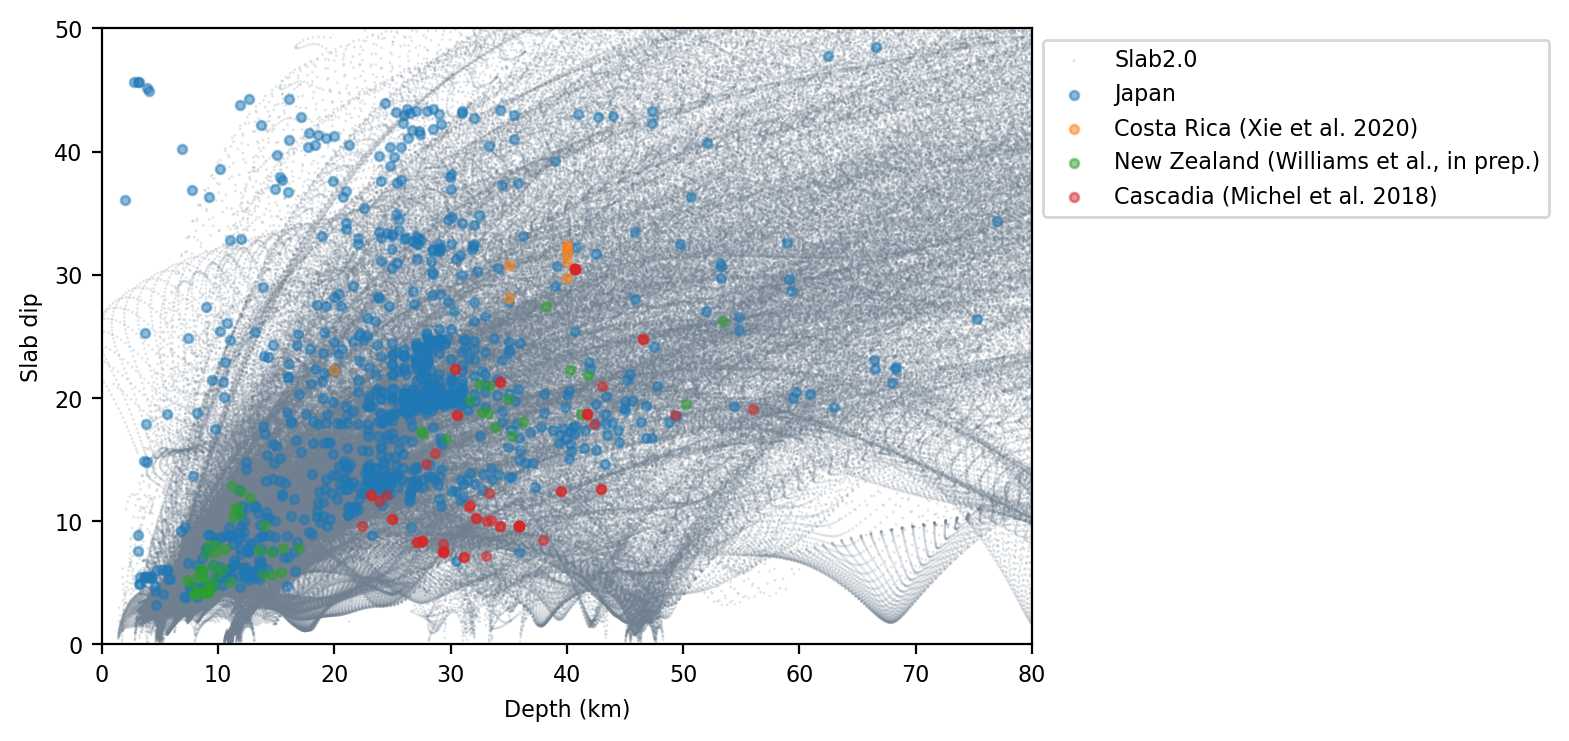

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(all_slabs.depth/1000, all_slabs.dip,s=1,edgecolors=[],alpha=0.2,c='slategrey', label='Slab2.0')
for i_slowslip in slowslip:
    if 'depth' in i_slowslip.catalog.columns:
        ax.scatter(
            i_slowslip.catalog['depth'],
            all_slabs.interpolate('dip', lon=i_slowslip.catalog['lon'], lat=i_slowslip.catalog['lat']),
            alpha=0.5,
            s = 10,
            label=i_slowslip.name,
        )
ax.set(
    ylabel='Slab dip',
    xlabel='Depth (km)',
    ylim=[0,50],
    xlim=[0,80],
)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

## Global stacking

### Time stacks

In [351]:
# for every slow slip event in the global compilation (all_slowslip) take a histogram of the earthquakes during the time window +/- T before the slow slip event and within W km from the SSE centroid
time_window = 720 # days

def get_earthquake_relative_times(
    catalog = all_slowslip,
    time_window = time_window, # days
    space_window = 100, # km 
    return_weights = True,
):

    relative_times = []
    weights = []

    for i,t in enumerate(catalog.catalog.time.values): 
        time_range = [
            t-np.timedelta64(time_window,'D')/2, 
            t+np.timedelta64(time_window,'D')/2
        ]
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            event_times = local_earthquakes.intersection(
                SlowSlipCatalog(catalog[[i]]),space_window # ...the spatial intersection of the slow slip event and the local earthquakes 
            ).get_time_slice(*time_range).catalog.time.values # ...within the time window
            
        if len(event_times) == 0:
            continue
        
        relative_times.append(event_times-t) 
        weights.append(1/len(event_times)*np.ones(len(event_times)))
        
    relative_times = np.concatenate(relative_times)
    weights = np.concatenate(weights)
    
    I = np.argsort(relative_times)
    relative_times = relative_times[I]/np.timedelta64(1,'D')
    weights = weights[I]
    
    if return_weights:
        return relative_times, weights
    else:
        return relative_times

relative_times, weights = get_earthquake_relative_times()

regional_relative_times = []
regionalized_weights = []

for region in slowslip:
    i_relative_times, i_weights = get_earthquake_relative_times(catalog = region)
    i_weights = i_weights/len(i_relative_times)
    regional_relative_times.append(i_relative_times)
    regionalized_weights.append(i_weights)

regional_relative_times = np.concatenate(regional_relative_times)
regionalized_weights = np.concatenate(regionalized_weights)

Text(0, 0.5, 'Earthquakes')

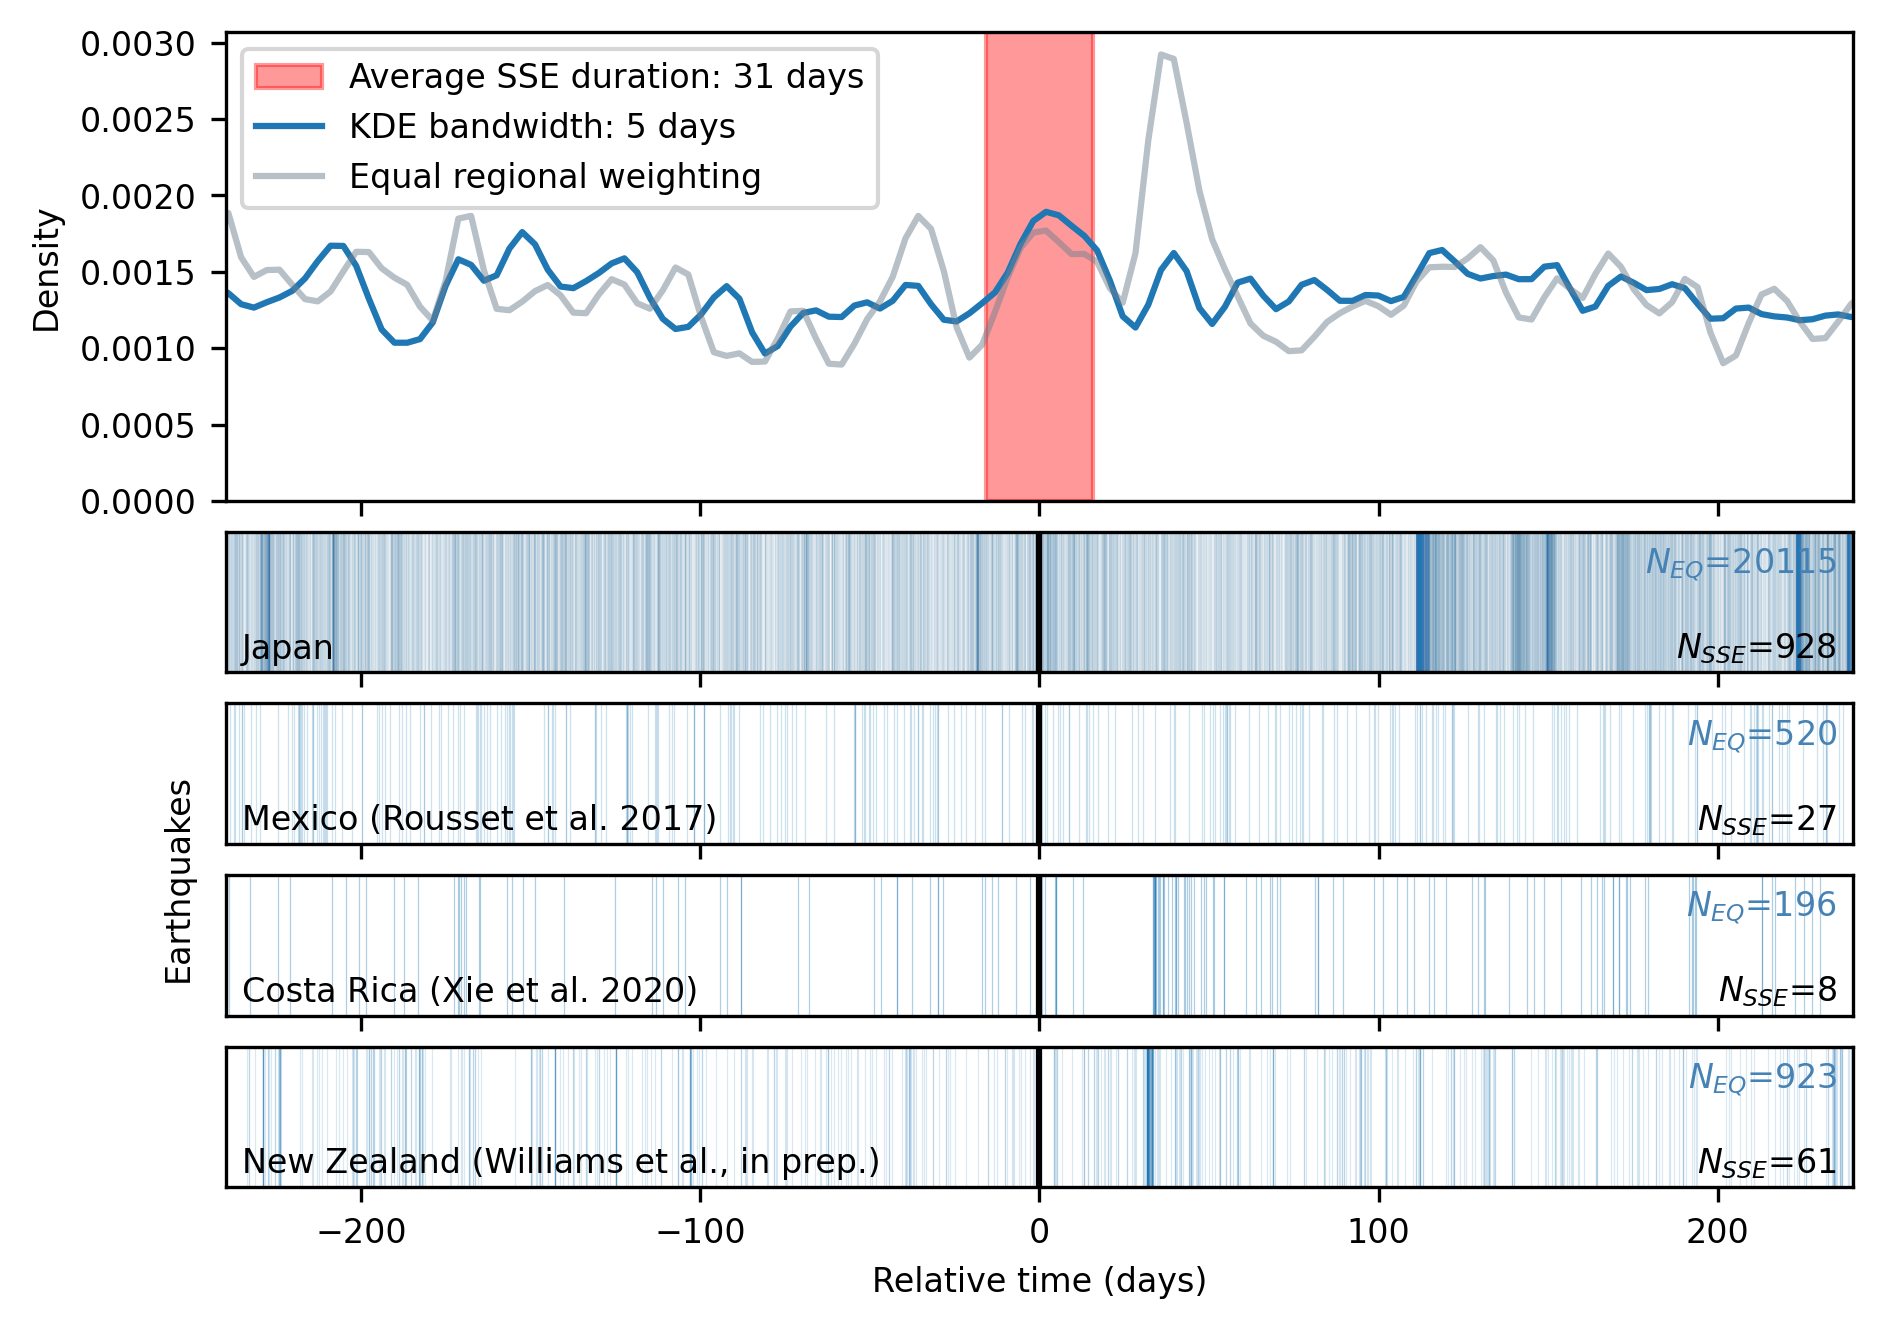

In [379]:
fig, AX = plt.subplots(len(slowslip)+1, 1, figsize=(7,5), sharex=True, gridspec_kw=dict(hspace=0.15, height_ratios=[1]+len(slowslip)*[0.3]))
data_std = np.std(relative_times)
smoothing_bandwidth = 5
bw = smoothing_bandwidth/data_std

average_duration = all_slowslip.catalog['duration'].mean()/60/60/24 
AX[0].axvspan(-average_duration/2, average_duration/2, color='red', alpha=0.4, label=f'Average SSE duration: {average_duration:.0f} days')
sns.kdeplot(
    x=relative_times,
    label=f"KDE bandwidth: {smoothing_bandwidth} days", 
    ax=AX[0],
    **dict(bw_method=bw, weights=weights)
)
sns.kdeplot(
    x=regional_relative_times,
    ax=AX[0], 
    color='slategray',
    label="Equal regional weighting",
    alpha=0.5,
    **dict(bw_method=bw, weights=regionalized_weights),
)
AX[0].legend(loc='upper left')


for region, iax in zip(slowslip, AX[1:]):
    times = get_earthquake_relative_times(region)[0]
    sns.rugplot(times, ax=iax, label=f'{region.name}', height=1, lw=0.3, alpha=5/np.sqrt(len(times))) 
    iax.set(
        yticks=[],
    )
    iax.text(0.01,0.1,region.name,transform=iax.transAxes)
    iax.text(0.99,0.1,"$N_{SSE}$" + f"={len(region)}",transform=iax.transAxes, ha='right')
    iax.text(0.99,0.9,"$N_{EQ}$" + f"={len(times)}",transform=iax.transAxes, ha='right', va='top', color='steelblue')
    iax.axvline(0, color='k')


AX[-1].set(
    xlabel='Relative time (days)',
    xlim=[-time_window/3,time_window/3],
)

AX[2].set_ylabel('Earthquakes', ha='right')

### Spatial stacks

In [ ]:
import multiprocessing as mp

def spatial_stack(
    time_window, 
    space_window, 
    slowslip_events: SlowSlipCatalog = all_slowslip, 
    earthquakes: EarthquakeCatalog = local_earthquakes,
    time_shift = 0,
):
    slowslip_events.catalog["strike"] = all_slabs.interpolate(
        'strike', 
        lon=slowslip_events.catalog['lon'].to_numpy(), 
        lat=slowslip_events.catalog['lat'].to_numpy(),
    )
    event_stack = []
    
    def get_single_sequence(t,i):
    
        time_range = [
            t - time_window * np.timedelta64(1,'D')/2 + time_shift * np.timedelta64(1,'D'), 
            t + time_window * np.timedelta64(1,'D')/2 + time_shift * np.timedelta64(1,'D'),
        ]
        
        events = earthquakes.intersection(
            SlowSlipCatalog(slowslip_events[[i]]),space_window # ...the spatial intersection of the slow slip event and the local earthquakes
        ).get_time_slice(*time_range) # ...within the time window
        
        
        if len(events) > 1: # 1 because density calculation goes a bit haywire when there is only 1 event
            
            # get SSE centroid and dimensions, and strike/dip direction from slab
            centroid = slowslip_events.catalog[['lat','lon']].to_numpy()[i,:]
            strike = all_slabs.interpolate("strike",centroid[0],centroid[1])
            sse_east, sse_north, _, _ = all_slabs.force_ll2utm(centroid[0],centroid[1])
            sse_dimension = Scaling.magnitude_to_size(slowslip_events[i].mag, slowslip_events._stress_drop, "m")
            
            east, north, _, _ = all_slabs.force_ll2utm(
                events.catalog['lat'].values, events.catalog['lon'].values
            )
            
            # center and rotate earthquake east and north to strike direction
            xy = np.column_stack((east,north))
            xy = xy - np.array([sse_east, sse_north])
            xy = xy/sse_dimension
            
            R = np.array([
                [np.cos(strike*np.pi/180), -np.sin(strike*np.pi/180)],
                [np.sin(strike*np.pi/180), np.cos(strike*np.pi/180)],
            ])
            xy_rotated = (R @ xy.T).T
            
            return xy_rotated
        
    with mp.Pool() as pool:
        event_stack = pool.starmap(get_single_sequence, [(t,i) for i,t in enumerate(slowslip_events.catalog.time.values)])
    
    return event_stack

T_event = 30 # days
W = 500 # km
co_event_stack = spatial_stack(T_event,W, time_shift=0)

T_pre = 360
buffer = 30
pre_event_stack = spatial_stack(T_pre,W, time_shift= (-T_pre/2 - T_event/2 - buffer) )

In [330]:
def spatial_stack(
    time_window, 
    space_window, 
    slowslip_events: SlowSlipCatalog = all_slowslip, 
    earthquakes: EarthquakeCatalog = local_earthquakes,
    time_shift = 0,
):
    slowslip_events.catalog["strike"] = all_slabs.interpolate(
        'strike', 
        lon=slowslip_events.catalog['lon'].to_numpy(), 
        lat=slowslip_events.catalog['lat'].to_numpy(),
    )
    event_stack = []
    for i,t in tqdm(enumerate(slowslip_events.catalog.time.values)):
        
        time_range = [
            t - time_window * np.timedelta64(1,'D')/2 + time_shift * np.timedelta64(1,'D'), 
            t + time_window * np.timedelta64(1,'D')/2 + time_shift * np.timedelta64(1,'D'),
        ]
        
        events = earthquakes.intersection(
            SlowSlipCatalog(slowslip_events[[i]]),space_window # ...the spatial intersection of the slow slip event and the local earthquakes
        ).get_time_slice(*time_range) # ...within the time window
        
        
        if len(events) > 1: # 1 because density calculation goes a bit haywire when there is only 1 event
            
            # get SSE centroid and dimensions, and strike/dip direction from slab
            centroid = slowslip_events.catalog[['lat','lon']].to_numpy()[i,:]
            strike = all_slabs.interpolate("strike",centroid[0],centroid[1])
            sse_east, sse_north, _, _ = all_slabs.force_ll2utm(centroid[0],centroid[1])
            sse_dimension = Scaling.magnitude_to_size(slowslip_events[i].mag, slowslip_events._stress_drop, "m")
            
            east, north, _, _ = all_slabs.force_ll2utm(
                events.catalog['lat'].values, events.catalog['lon'].values
            )
            
            # center and rotate earthquake east and north to strike direction
            xy = np.column_stack((east,north))
            xy = xy - np.array([sse_east, sse_north])
            xy = xy/sse_dimension
            
            R = np.array([
                [np.cos(strike*np.pi/180), -np.sin(strike*np.pi/180)],
                [np.sin(strike*np.pi/180), np.cos(strike*np.pi/180)],
            ])
            xy_rotated = (R @ xy.T).T
            
            event_stack.append(xy_rotated)
    return event_stack

T_event = 30 # days
W = 500 # km
co_event_stack = spatial_stack(T_event,W, time_shift=0)

T_pre = 360
buffer = 30
pre_event_stack = spatial_stack(T_pre,W, time_shift= (-T_pre/2 - T_event/2 - buffer) )


1024it [05:25,  3.14it/s]
1024it [06:16,  2.72it/s]


/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kdascher/miniforge3/envs/torchETAS/

[Text(0.5, 0, 'Along-dip (SSE dimensions)')]

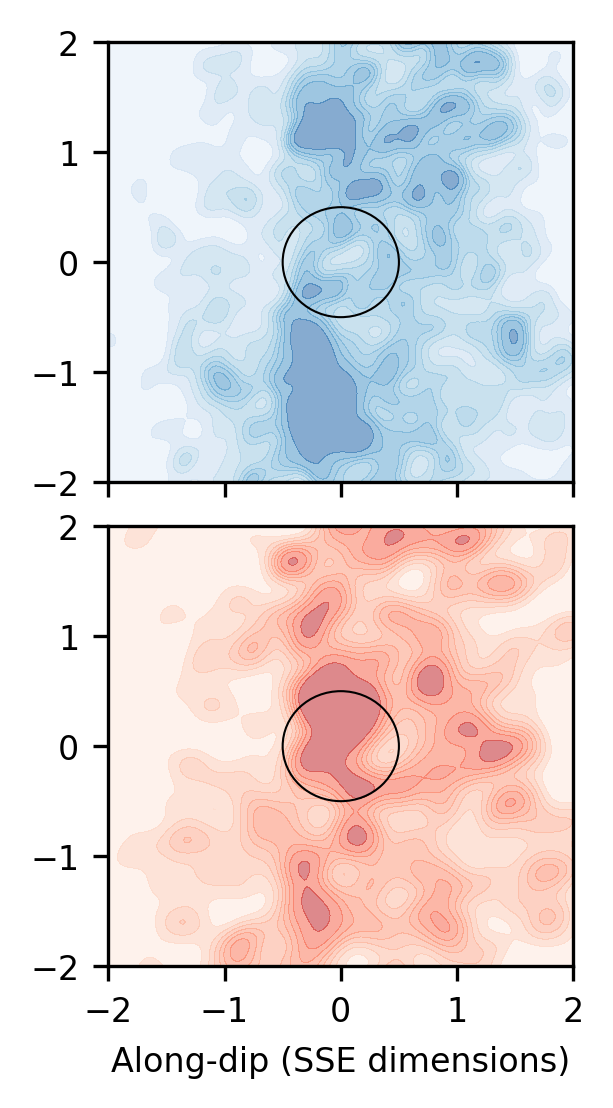

In [331]:
pre_event_stack_combined = np.concatenate(pre_event_stack)
co_event_stack_combined = np.concatenate(co_event_stack)

pre_weights = []
for seq in pre_event_stack:
    pre_weights.append(np.ones(len(seq))/len(seq))
pre_weights = np.concatenate(pre_weights)

co_weights = []
for seq in co_event_stack:
    co_weights.append(np.ones(len(seq))/len(seq))
co_weights = np.concatenate(co_weights)

# drop nan values in both stacks and corresponding weights
pre_weights = pre_weights[~np.isnan(pre_event_stack_combined).any(axis=1)]
co_weights = co_weights[~np.isnan(co_event_stack_combined).any(axis=1)]
pre_event_stack_combined = pre_event_stack_combined[~np.isnan(pre_event_stack_combined).any(axis=1)]
co_event_stack_combined = co_event_stack_combined[~np.isnan(co_event_stack_combined).any(axis=1)]


fig, ax = plt.subplots(2,1,figsize=(2,4), sharex=True, sharey=True, gridspec_kw=dict(hspace=0.1))
shared_kws = dict(
    shade=True,
    shade_lowest=False,
    alpha=0.5,
    clip=[-2,2],
    bw_adjust=0.1,
    levels=np.linspace(0,1,10),
)

sns.kdeplot(pre_event_stack_combined[:,0], pre_event_stack_combined[:,1], cmap='Blues', label='Pre-event', ax=ax[0], **shared_kws, weights=pre_weights)
sns.kdeplot(co_event_stack_combined[:,0], co_event_stack_combined[:,1], cmap='Reds', label='During slow slip', ax=ax[1], **shared_kws, weights=co_weights)  

for iax in ax:
    # plot a circle to show the SSE dimensions
    iax.add_artist(plt.Circle((0, 0), 0.5, color='k', fill=False, lw=0.5))

ax[1].set(
    xlabel='Along-dip (SSE dimensions)',
)
    

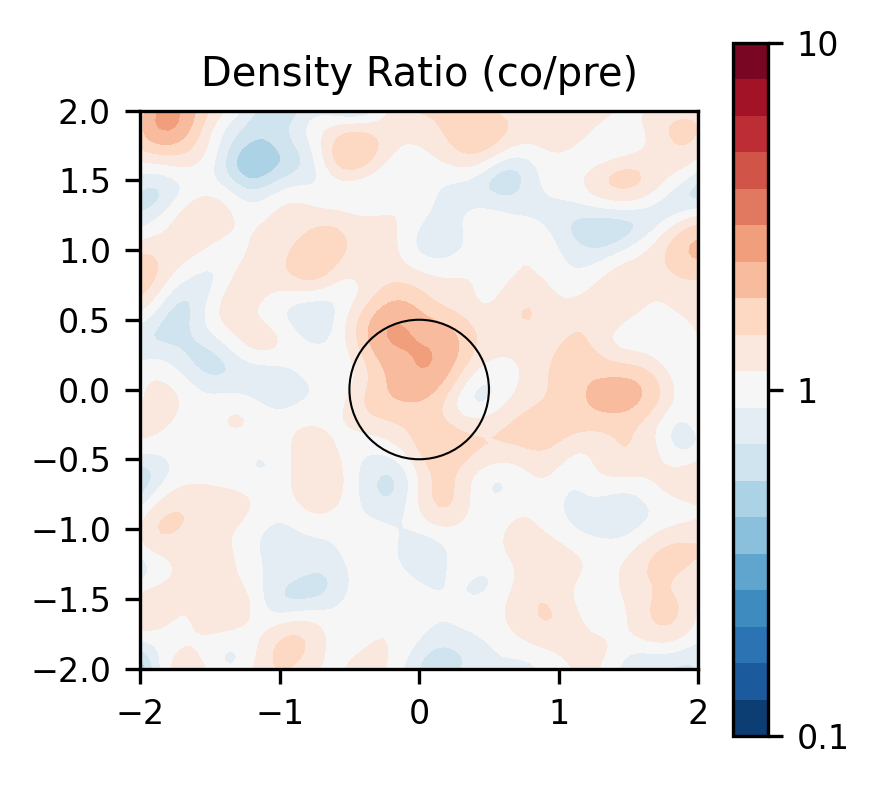

In [332]:


# Define the bandwidth for smoothing
smoothing_bandwidth = 0.03

# Create the kernel density estimators
dens_pre = gaussian_kde(pre_event_stack_combined.T, bw_method=smoothing_bandwidth, weights=pre_weights)
dens_co = gaussian_kde(co_event_stack_combined.T, bw_method=smoothing_bandwidth, weights=co_weights)

# Define the range and grid
number_of_source_dimensions = 2
xmin, xmax = -number_of_source_dimensions, number_of_source_dimensions
ymin, ymax = -number_of_source_dimensions, number_of_source_dimensions
grid_size = 100

# Create a grid of points
xx, yy = np.meshgrid(np.linspace(xmin, xmax, grid_size), np.linspace(ymin, ymax, grid_size))
grid_points = np.column_stack((xx.flatten(), yy.flatten()))

# Evaluate the density ratio on the grid
density_ratio = dens_co(grid_points.T) / dens_pre(grid_points.T)
density_ratio = density_ratio.reshape(xx.shape)

# Plot the contour map
fig, ax = plt.subplots(figsize=(3, 3))
ch = ax.contourf(xx, yy, np.log10(density_ratio), levels=np.linspace(-1, 1, 20), cmap='RdBu_r')
cax = plt.colorbar(ch)
cax.set_ticks([-1, 0, 1])
cax.set_ticklabels(['0.1', '1', '10'])
ax.add_artist(plt.Circle((0, 0), 0.5, color='k', fill=False, lw=0.5))
ax.set_aspect('equal')

ax.set_title('Density Ratio (co/pre)')

plt.show()

/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kdascher/miniforge3/envs/torchETAS/

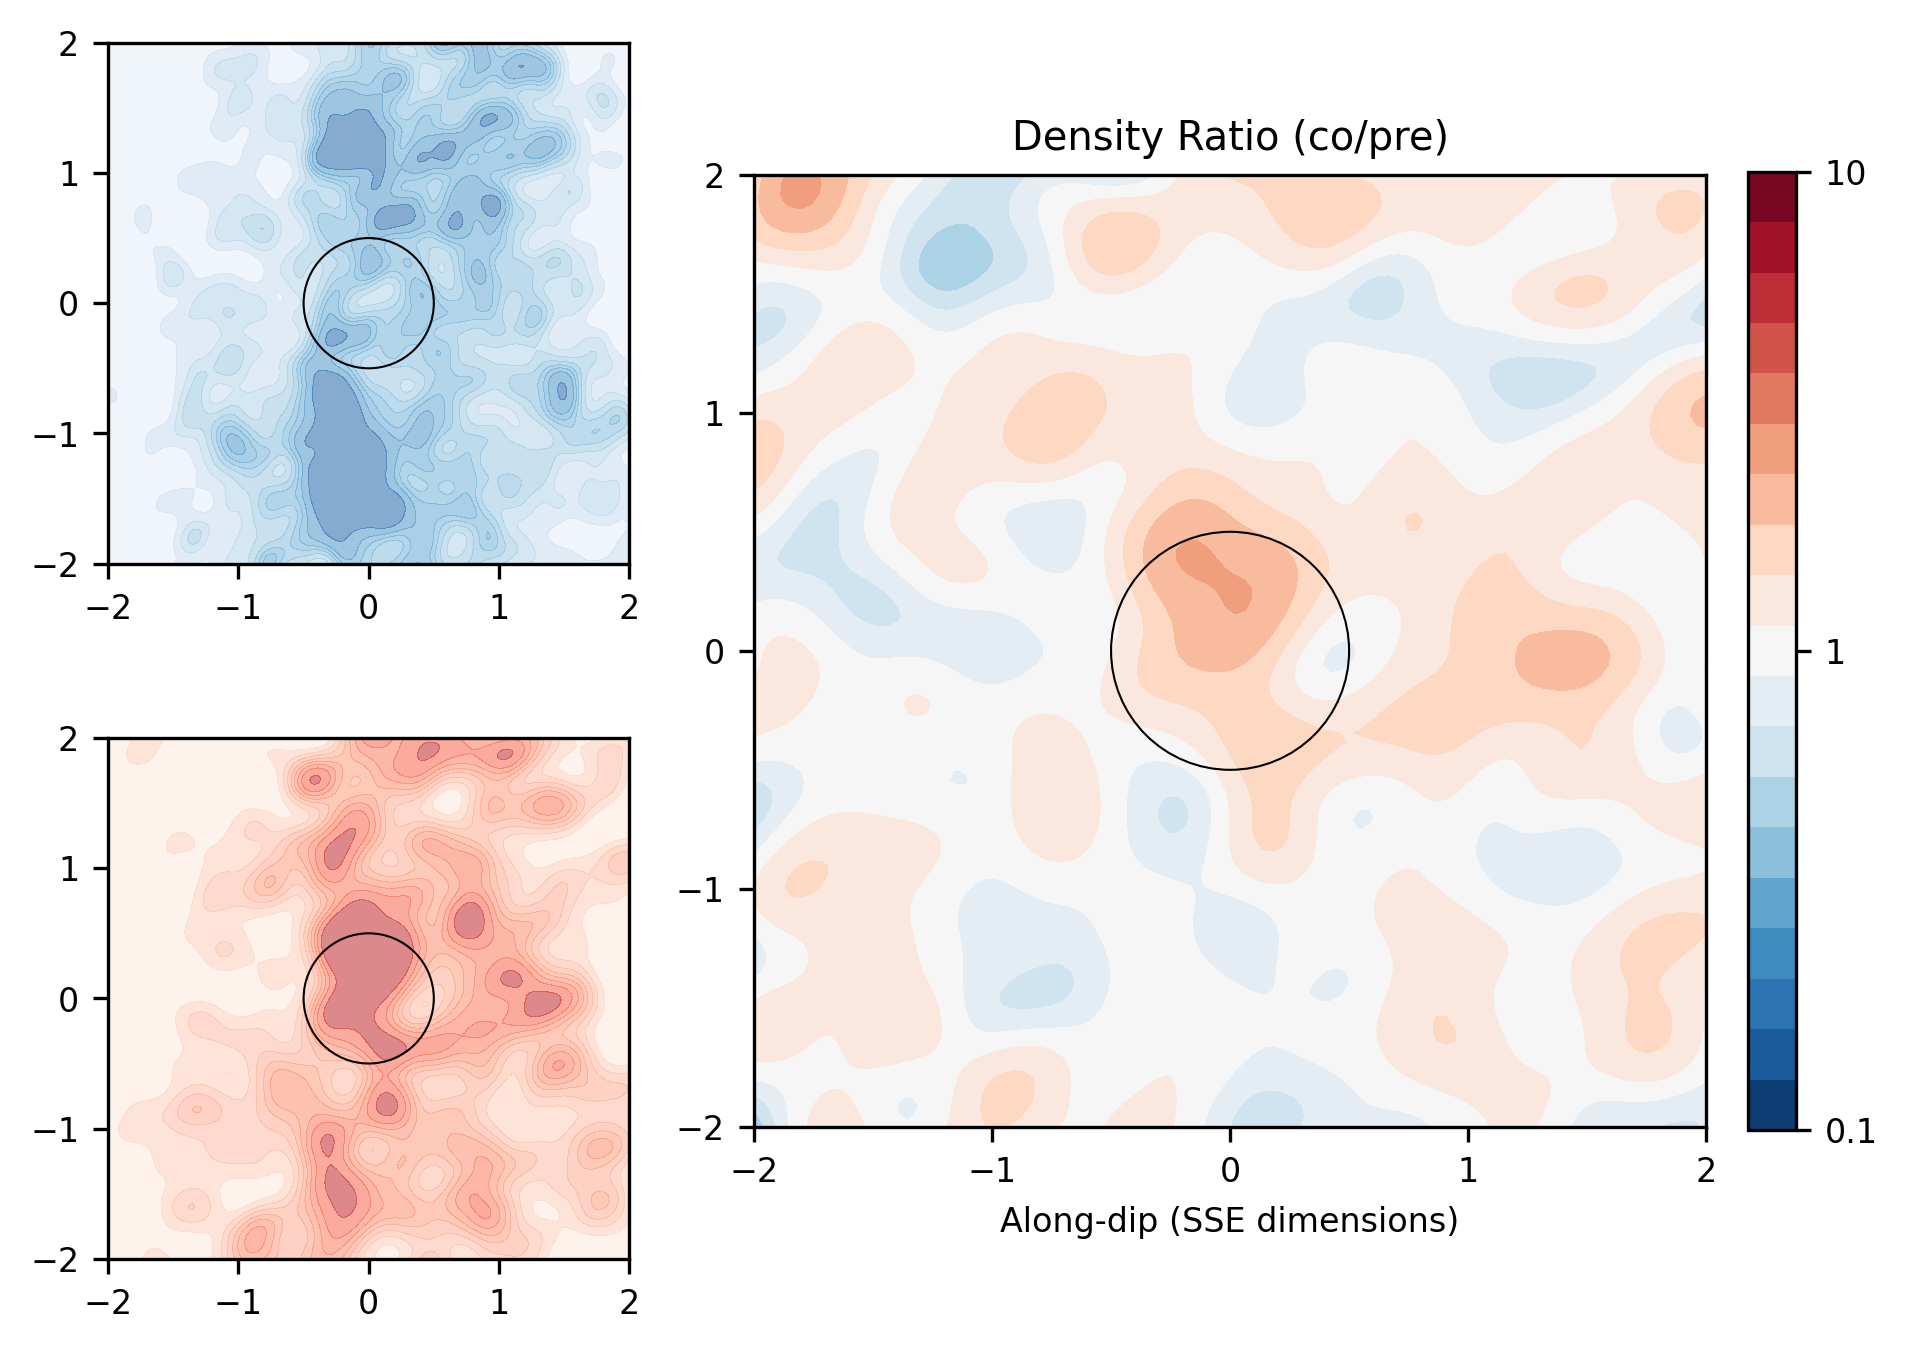

In [333]:
# Create a 2x2 grid with ratios [1, 1, 2] for the row heights
gs = mpl.gridspec.GridSpec(2, 2, width_ratios=[1, 2])

# Subplot 1 - Top plot
ax1 = plt.subplot(gs[0, 0])  # First row, first column
sns.kdeplot(pre_event_stack_combined[:,0], pre_event_stack_combined[:,1], cmap='Blues', label='Pre-event', ax=ax1, **shared_kws, weights=pre_weights)



# Subplot 2 - Bottom plot
ax2 = plt.subplot(gs[1, 0])  # Second row, first column
sns.kdeplot(co_event_stack_combined[:,0], co_event_stack_combined[:,1], cmap='Reds', label='During slow slip', ax=ax2, **shared_kws, weights=co_weights)  


# Subplot 3 - Right plot
ax3 = plt.subplot(gs[:, 1])  # All rows, second column
ch = ax3.contourf(xx, yy, np.log10(density_ratio), levels=np.linspace(-1, 1, 20), cmap='RdBu_r')
# plot colorbar sized to the specific plot
cax3 = plt.colorbar(ch, ax=ax3, fraction=0.046, pad=0.04)

cax3.set_ticks([-1, 0, 1])
cax3.set_ticklabels(['0.1', '1', '10'])
ax3.set(
    xlabel='Along-dip (SSE dimensions)',
)


ax3.set_title('Density Ratio (co/pre)')

for iax in [ax1,ax2,ax3]:
    iax.add_artist(plt.Circle((0, 0), 0.5, color='k', fill=False, lw=0.5))
    iax.set(
        aspect='equal',
        xticks=[-2,-1,0,1,2],
        yticks=[-2,-1,0,1,2],
    )
plt.tight_layout()



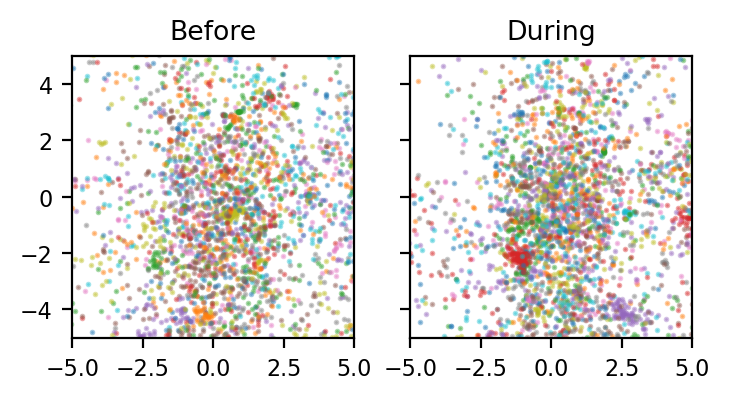

In [59]:
lim = 5
fig, AX = plt.subplots(1,2,figsize=(4,4),sharex=True,sharey=True)
for ax, stack, title in zip(AX, [pre_event_stack, co_event_stack], ['Before','During']):
    [ax.scatter(events[:,0],events[:,1],s=1,alpha=0.4) for events in stack]
    ax.set(
        xlim=np.array([-lim,lim]),
        ylim=np.array([-lim,lim]),
        aspect='equal',
        title=title,
    )